In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle

In [11]:
EMBEDD_DIR = 'embeddings/'

In [27]:
EMBEDD_DATA = {}

for p in os.listdir(EMBEDD_DIR):
    if 'epoch' in p:
        epoch = p.replace('.pt', '').split('epoch_')[1].split('_')[0]
        split = p.replace('.pkl', '').split('_')[-1]
        with open(f'{EMBEDD_DIR}{p}', 'rb') as f:
            values = pickle.load(f)
        if 'epoch_'+str(epoch) in EMBEDD_DATA.keys():
            EMBEDD_DATA['epoch_'+str(epoch)][split] = values
        else:
            EMBEDD_DATA['epoch_'+str(epoch)] = {}
            EMBEDD_DATA['epoch_'+str(epoch)][split] = values

In [28]:
EMBEDD_DATA['epoch_979']['train'].shape, EMBEDD_DATA['epoch_979']['val'].shape

((66809, 768), (7494, 768))

In [32]:
pretrain_meta_data_train = pd.read_csv('data_csv/mae_UKB_ADNI_HCP_CamCAN_IXI_train_with_stat.csv')
pretrain_meta_data_train.fillna(-99, inplace=True)
pretrain_meta_data_val = pd.read_csv('data_csv/mae_UKB_ADNI_HCP_CamCAN_IXI_val_with_stat.csv') 
pretrain_meta_data_val.fillna(-99, inplace=True)


/tmp/ipykernel_581086/3999993595.py:1: DtypeWarning: Columns (2,3,5,7,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pretrain_meta_data_train = pd.read_csv('data_csv/mae_UKB_ADNI_HCP_CamCAN_IXI_train_with_stat.csv')
/tmp/ipykernel_581086/3999993595.py:3: DtypeWarning: Columns (2,3,5,7,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pretrain_meta_data_val = pd.read_csv('data_csv/mae_UKB_ADNI_HCP_CamCAN_IXI_val_with_stat.csv')


In [90]:
pretrain_meta_data_val.columns[21:]

Index(['Left-Lateral-Ventricle_Volume_mm3', 'Left-Inf-Lat-Vent_Volume_mm3',
       'Left-Cerebellum-White-Matter_Volume_mm3',
       'Left-Cerebellum-Cortex_Volume_mm3', 'Left-Thalamus_Volume_mm3',
       'Left-Caudate_Volume_mm3', 'Left-Putamen_Volume_mm3',
       'Left-Pallidum_Volume_mm3', '3rd-Ventricle_Volume_mm3',
       '4th-Ventricle_Volume_mm3',
       ...
       'CerebralWhiteMatterVol', 'TotalGrayVol', 'SupraTentorialVolNotVent',
       'BrainSegVol-to-eTIV', 'lhSurfaceHoles', 'SurfaceHoles', 'NumVert',
       'MeanThickness', 'BrainSegVolNotVent', 'CortexVol'],
      dtype='object', length=161)

# linear prob 

In [91]:
partial_task = ['age', 'gender', 'BrainSegVol', 'CortexVol', 'Left-Hippocampus_Volume_mm3']

all_task = ['age', 'gender'] + pretrain_meta_data_val.columns[21:].to_list()

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from scipy.stats import spearmanr 

LIN_PROB = {}
LIN_PROB_PRED = {}
for epoch in EMBEDD_DATA.keys():
    LIN_PROB[epoch] = {}
    LIN_PROB_PRED[epoch] = {}
    if 'train' in EMBEDD_DATA[epoch].keys() and 'val' in EMBEDD_DATA[epoch].keys():
        for target in all_task: # partial_task all_task
            LIN_PROB[epoch][target] = {}
            LIN_PROB_PRED[epoch][target] = {}
            # 1. Create a sample regression dataset (You can replace this with your own dataset)
            y_train = pretrain_meta_data_train[target]
            y_test = pretrain_meta_data_val[target]
            cond_train = y_train!=-99
            cond_test = y_test!=-99
            
            X_train = EMBEDD_DATA[epoch]['train'][cond_train]
            X_test = EMBEDD_DATA[epoch]['val'][cond_test]
            y_train = y_train[cond_train]
            y_test = y_test[cond_test]
            
            
            # 2. Create the pipeline with scaling and linear regression
            if target != 'gender':
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),      # Step 1: Standardize the data
                    ('regressor', LinearRegression())  # Step 2: Fit a linear regression model
                ])
            else:
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),      # Step 1: Standardize the data
                    ('classifier', LogisticRegression())  # Step 2: Fit a linear regression model
                ])
            
            # 3. Fit the pipeline on the training data
            pipeline.fit(X_train, y_train)
    
            if target != 'gender':
                # 4. Make predictions on the test set
                y_pred_train = pipeline.predict(X_train)
                y_pred_test = pipeline.predict(X_test)
                
                # 5. Evaluate the model
                r2_train = r2_score(y_train, y_pred_train)  # R-squared score
                spearmanr_train, _ = spearmanr(y_train, y_pred_train)
                r2_test = r2_score(y_test, y_pred_test)  # R-squared score
                spearmanr_test, _ = spearmanr(y_test, y_pred_test)
                
                LIN_PROB[epoch][target]['r2_train'] = r2_train
                LIN_PROB[epoch][target]['r2_val'] = r2_test
                LIN_PROB[epoch][target]['spearmanr_train'] = spearmanr_train
                LIN_PROB[epoch][target]['spearmanr_val'] = spearmanr_test
                print(epoch, target, LIN_PROB[epoch][target]['r2_val'], LIN_PROB[epoch][target]['spearmanr_val'])
            else:
                # 4. Make predictions on the test set
                y_pred_train = pipeline.predict_proba(X_train)[:, 1]
                y_pred_test = pipeline.predict_proba(X_test)[:, 1]
                
                # 5. Evaluate the model
                auc_train = roc_auc_score(y_train, y_pred_train)  # auc score
                auc_test = roc_auc_score(y_test, y_pred_test)  # auc score
                
                LIN_PROB[epoch][target]['auc_train'] = auc_train
                LIN_PROB[epoch][target]['auc_val'] = auc_test
                

epoch_359 age 0.7351818920378075 0.8557081771505294
epoch_359 Left-Lateral-Ventricle_Volume_mm3 0.9457804669815456 0.9693062196258991
epoch_359 Left-Inf-Lat-Vent_Volume_mm3 0.7253741481055991 0.787043712617767
epoch_359 Left-Cerebellum-White-Matter_Volume_mm3 0.6475448511359057 0.8044872017804221
epoch_359 Left-Cerebellum-Cortex_Volume_mm3 0.6553696192011826 0.8052027903596525
epoch_359 Left-Thalamus_Volume_mm3 0.7306118817292535 0.8513621453080267
epoch_359 Left-Caudate_Volume_mm3 0.512442427688406 0.7075367992388754
epoch_359 Left-Putamen_Volume_mm3 0.5570712525568262 0.7459649557145185
epoch_359 Left-Pallidum_Volume_mm3 0.5812047717730033 0.7616794100878725
epoch_359 3rd-Ventricle_Volume_mm3 0.7737699840638974 0.8937236579053651
epoch_359 4th-Ventricle_Volume_mm3 0.48365245448870564 0.6891447445539591
epoch_359 Brain-Stem_Volume_mm3 0.7856449842653004 0.8814783648644587
epoch_359 Left-Hippocampus_Volume_mm3 0.6162209598288575 0.7796901606335328
epoch_359 Left-Amygdala_Volume_mm3 0.5

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_359 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_359 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_359 non-WM-hypointensities_Volume_mm3 -1.121299834376888 0.03715349922809751


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_359 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_359 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_359 Optic-Chiasm_Volume_mm3 0.4720335421918922 0.6977131940383445
epoch_359 CC_Posterior_Volume_mm3 0.629607854373598 0.8307175482986893
epoch_359 CC_Mid_Posterior_Volume_mm3 0.40412554027269587 0.675821678029442
epoch_359 CC_Central_Volume_mm3 0.4877598799817563 0.7307144707305837
epoch_359 CC_Mid_Anterior_Volume_mm3 0.5088629747923713 0.7540916686713804
epoch_359 CC_Anterior_Volume_mm3 0.6590081784845638 0.8105655995299877
epoch_359 bankssts_SurfArea 0.40504567424666627 0.6355975324529466
epoch_359 bankssts_GrayVol 0.37740140384898113 0.611652614751474
epoch_359 bankssts_ThickAvg 0.22772459286248437 0.45381497283955996
epoch_359 caudalanteriorcingulate_SurfArea 0.26882344474089725 0.5155802204498865
epoch_359 caudalanteriorcingulate_GrayVol 0.1951681790699883 0.4277384219766425
epoch_359 caudalanteriorcingulate_ThickAvg 0.1683398773605691 0.3995591055701299
epoch_359 caudalmiddlefrontal_SurfArea 0.5048658520271626 0.7045

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_379 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_379 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_379 non-WM-hypointensities_Volume_mm3 -1.1774144722666842 0.030690677115061484


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_379 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_379 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_379 Optic-Chiasm_Volume_mm3 0.4689727792534836 0.6957573436219231
epoch_379 CC_Posterior_Volume_mm3 0.6282344294844859 0.8298771525981822
epoch_379 CC_Mid_Posterior_Volume_mm3 0.40232954311299785 0.6725525971551125
epoch_379 CC_Central_Volume_mm3 0.48871208602204397 0.7290293695218477
epoch_379 CC_Mid_Anterior_Volume_mm3 0.5037458377237536 0.7477248026531742
epoch_379 CC_Anterior_Volume_mm3 0.6490950569002749 0.8046326484241738
epoch_379 bankssts_SurfArea 0.4043427029506599 0.6354935529242067
epoch_379 bankssts_GrayVol 0.37824045049983757 0.6106683414632927
epoch_379 bankssts_ThickAvg 0.22684187776238218 0.4546851684051236
epoch_379 caudalanteriorcingulate_SurfArea 0.26712206883162126 0.5126838925987084
epoch_379 caudalanteriorcingulate_GrayVol 0.19304345552983526 0.423788698677279
epoch_379 caudalanteriorcingulate_ThickAvg 0.17077840036831948 0.40004939702776005
epoch_379 caudalmiddlefrontal_SurfArea 0.504419440726451 0.7

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_199 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_199 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_199 non-WM-hypointensities_Volume_mm3 -0.7867455140038027 0.05004934040493765


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_199 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_199 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_199 Optic-Chiasm_Volume_mm3 0.43681643351206556 0.6732215431024456
epoch_199 CC_Posterior_Volume_mm3 0.5732691013803908 0.7953311342494538
epoch_199 CC_Mid_Posterior_Volume_mm3 0.37085313827393784 0.6420434570475759
epoch_199 CC_Central_Volume_mm3 0.4595709537731124 0.7029184976735264
epoch_199 CC_Mid_Anterior_Volume_mm3 0.4802982015118257 0.7243743789021446
epoch_199 CC_Anterior_Volume_mm3 0.6170386793069175 0.7852309068283705
epoch_199 bankssts_SurfArea 0.38187085119807507 0.6152751486317997
epoch_199 bankssts_GrayVol 0.36560273475053806 0.5974248504511512
epoch_199 bankssts_ThickAvg 0.1972778220277831 0.4219264372346237
epoch_199 caudalanteriorcingulate_SurfArea 0.25189049664080165 0.4976574444659835
epoch_199 caudalanteriorcingulate_GrayVol 0.18072834869053245 0.40838461431764655
epoch_199 caudalanteriorcingulate_ThickAvg 0.15131192264300775 0.3716873070555804
epoch_199 caudalmiddlefrontal_SurfArea 0.4824402945356754 0

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_159 Left-Lateral-Ventricle_Volume_mm3 0.9447336552172847 0.9669617786875299
epoch_159 Left-Inf-Lat-Vent_Volume_mm3 0.7131659235005425 0.7725283798780606
epoch_159 Left-Cerebellum-White-Matter_Volume_mm3 0.6013379108940311 0.7735254182471415
epoch_159 Left-Cerebellum-Cortex_Volume_mm3 0.6303876405907209 0.7881761746247767
epoch_159 Left-Thalamus_Volume_mm3 0.6940244160328757 0.8282200194725969
epoch_159 Left-Caudate_Volume_mm3 0.42370185444933606 0.6453078712954056
epoch_159 Left-Putamen_Volume_mm3 0.5123632442134066 0.7129959394211183
epoch_159 Left-Pallidum_Volume_mm3 0.5479142762152257 0.7362972398540341
epoch_159 3rd-Ventricle_Volume_mm3 0.7513979046220679 0.8800575434991418
epoch_159 4th-Ventricle_Volume_mm3 0.4119862228109965 0.6388958994819859
epoch_159 Brain-Stem_Volume_mm3 0.708450023643525 0.8344380416436131
epoch_159 Left-Hippocampus_Volume_mm3 0.5958979329533692 0.7622746290685877
epoch_159 Left-Amygdala_Volume_mm3 0.5172127059726952 0.7057558106130315
epoch_159 CSF_Vo

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_159 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_159 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_159 non-WM-hypointensities_Volume_mm3 -0.6679628753724385 0.05079502441955363


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_159 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_159 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_159 Optic-Chiasm_Volume_mm3 0.4245564686329425 0.6621644421113202
epoch_159 CC_Posterior_Volume_mm3 0.5588150964203505 0.7856682184816226
epoch_159 CC_Mid_Posterior_Volume_mm3 0.3593263111312742 0.6302511978476281
epoch_159 CC_Central_Volume_mm3 0.4407894674762258 0.6906956265611541
epoch_159 CC_Mid_Anterior_Volume_mm3 0.46190961136660225 0.7143001695343518
epoch_159 CC_Anterior_Volume_mm3 0.5928811829165 0.7686723067447753
epoch_159 bankssts_SurfArea 0.3640199681396853 0.604692655449934
epoch_159 bankssts_GrayVol 0.35081478210895845 0.5881392874973803
epoch_159 bankssts_ThickAvg 0.17702984007153244 0.39586481250713873
epoch_159 caudalanteriorcingulate_SurfArea 0.24754607297016284 0.4960639542364403
epoch_159 caudalanteriorcingulate_GrayVol 0.1782872292613119 0.40266621900082733
epoch_159 caudalanteriorcingulate_ThickAvg 0.14707352133911278 0.36687187835910984
epoch_159 caudalmiddlefrontal_SurfArea 0.4705797220301263 0.678

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_979 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_979 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_979 non-WM-hypointensities_Volume_mm3 -1.8599814189649435 0.020857548557636194


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_979 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_979 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_979 Optic-Chiasm_Volume_mm3 0.4835060523820808 0.7046921623765201
epoch_979 CC_Posterior_Volume_mm3 0.6467991315049808 0.8421975167961395
epoch_979 CC_Mid_Posterior_Volume_mm3 0.43465492106874115 0.6984991494423575
epoch_979 CC_Central_Volume_mm3 0.5167942733708256 0.7504035170520456
epoch_979 CC_Mid_Anterior_Volume_mm3 0.5265391939267083 0.7688242464258626
epoch_979 CC_Anterior_Volume_mm3 0.6700395436238682 0.8185025367559741
epoch_979 bankssts_SurfArea 0.4209255626743045 0.6532322441199704
epoch_979 bankssts_GrayVol 0.3896179086957472 0.6217846947291653
epoch_979 bankssts_ThickAvg 0.2501443512247916 0.4907425054652251
epoch_979 caudalanteriorcingulate_SurfArea 0.28359752093442836 0.5263621725611382
epoch_979 caudalanteriorcingulate_GrayVol 0.2038792530225525 0.4370293395362793
epoch_979 caudalanteriorcingulate_ThickAvg 0.19062551750578338 0.4327071284011061
epoch_979 caudalmiddlefrontal_SurfArea 0.5364151485057331 0.7289

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_119 Left-Lateral-Ventricle_Volume_mm3 0.9408910660075857 0.9635721005613147
epoch_119 Left-Inf-Lat-Vent_Volume_mm3 0.6964924500417997 0.7652903691004661
epoch_119 Left-Cerebellum-White-Matter_Volume_mm3 0.5701496964831338 0.7571168173789502
epoch_119 Left-Cerebellum-Cortex_Volume_mm3 0.6086543660117121 0.7741421854823863
epoch_119 Left-Thalamus_Volume_mm3 0.6786441005967335 0.8182817462639258
epoch_119 Left-Caudate_Volume_mm3 0.37916624690508427 0.6076758984416202
epoch_119 Left-Putamen_Volume_mm3 0.4737265779495283 0.6840661028307397
epoch_119 Left-Pallidum_Volume_mm3 0.5221631812493823 0.719349755496486
epoch_119 3rd-Ventricle_Volume_mm3 0.7469865200714172 0.8812508587798645
epoch_119 4th-Ventricle_Volume_mm3 0.3756035200021274 0.6074776827063355
epoch_119 Brain-Stem_Volume_mm3 0.6657127059632637 0.809574420584777
epoch_119 Left-Hippocampus_Volume_mm3 0.5688525939385167 0.7497138182678981
epoch_119 Left-Amygdala_Volume_mm3 0.4815801849765329 0.6829879937759329
epoch_119 CSF_Vol

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_119 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_119 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_119 non-WM-hypointensities_Volume_mm3 -0.5423677337429138 0.035627032073920935


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_119 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_119 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_119 Optic-Chiasm_Volume_mm3 0.38932637113720003 0.6326440255930336
epoch_119 CC_Posterior_Volume_mm3 0.5182915179719085 0.7546281109208672
epoch_119 CC_Mid_Posterior_Volume_mm3 0.3443742010401656 0.617044954721251
epoch_119 CC_Central_Volume_mm3 0.4196870949737268 0.6704651678116845
epoch_119 CC_Mid_Anterior_Volume_mm3 0.4341377990460824 0.6875333236546587
epoch_119 CC_Anterior_Volume_mm3 0.5410188074464113 0.7319372477268689
epoch_119 bankssts_SurfArea 0.33283206214017824 0.5797950121003252
epoch_119 bankssts_GrayVol 0.3211926243432218 0.5611205801413187
epoch_119 bankssts_ThickAvg 0.15502604698220435 0.3709816291724033
epoch_119 caudalanteriorcingulate_SurfArea 0.22833515545339444 0.47863786487392235
epoch_119 caudalanteriorcingulate_GrayVol 0.1622606190068444 0.387505404514357
epoch_119 caudalanteriorcingulate_ThickAvg 0.1297907308540287 0.34406754786974647
epoch_119 caudalmiddlefrontal_SurfArea 0.4411124666182543 0.656

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_59 Left-Lateral-Ventricle_Volume_mm3 0.9272264692490442 0.9571603556811774
epoch_59 Left-Inf-Lat-Vent_Volume_mm3 0.6855933871257711 0.7562528956499187
epoch_59 Left-Cerebellum-White-Matter_Volume_mm3 0.5058339810402148 0.7271774267916191
epoch_59 Left-Cerebellum-Cortex_Volume_mm3 0.5527377790904746 0.7412497434637977
epoch_59 Left-Thalamus_Volume_mm3 0.633327398428299 0.7955498281316955
epoch_59 Left-Caudate_Volume_mm3 0.3305765809291872 0.55967813969042
epoch_59 Left-Putamen_Volume_mm3 0.4154257352618018 0.6453985522702211
epoch_59 Left-Pallidum_Volume_mm3 0.4737110191206313 0.6970829465757088
epoch_59 3rd-Ventricle_Volume_mm3 0.7327040639066675 0.870734818271863
epoch_59 4th-Ventricle_Volume_mm3 0.3292640747612501 0.5784841823424827
epoch_59 Brain-Stem_Volume_mm3 0.6106285583060697 0.7851728769280925
epoch_59 Left-Hippocampus_Volume_mm3 0.5329474236360334 0.7271509296713736
epoch_59 Left-Amygdala_Volume_mm3 0.4461838733082114 0.6604690575058365
epoch_59 CSF_Volume_mm3 0.5097583

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_59 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_59 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_59 non-WM-hypointensities_Volume_mm3 -0.5737699947795598 0.020524324890280915


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_59 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_59 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_59 Optic-Chiasm_Volume_mm3 0.3745283544721738 0.6221668301635571
epoch_59 CC_Posterior_Volume_mm3 0.43852155763954925 0.7069389615138142
epoch_59 CC_Mid_Posterior_Volume_mm3 0.3306790421086272 0.6064692109204847
epoch_59 CC_Central_Volume_mm3 0.39489481011524397 0.6608381778956494
epoch_59 CC_Mid_Anterior_Volume_mm3 0.4020321352852806 0.6713659083803363
epoch_59 CC_Anterior_Volume_mm3 0.48474618394033886 0.7019953524132322
epoch_59 bankssts_SurfArea 0.27818944084944863 0.5279300931263006
epoch_59 bankssts_GrayVol 0.27092058486536263 0.5134046537314302
epoch_59 bankssts_ThickAvg 0.11610401818929905 0.3169300181558283
epoch_59 caudalanteriorcingulate_SurfArea 0.20203658931553814 0.44947417173067233
epoch_59 caudalanteriorcingulate_GrayVol 0.14079579869316527 0.3633576938053948
epoch_59 caudalanteriorcingulate_ThickAvg 0.09258655908918478 0.2981255400955977
epoch_59 caudalmiddlefrontal_SurfArea 0.3840277025239349 0.60840672204

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_39 Left-Lateral-Ventricle_Volume_mm3 0.9163729782273462 0.9495756474954179
epoch_39 Left-Inf-Lat-Vent_Volume_mm3 0.6531952859559296 0.7471669434128596
epoch_39 Left-Cerebellum-White-Matter_Volume_mm3 0.46525401397142885 0.7077358344530698
epoch_39 Left-Cerebellum-Cortex_Volume_mm3 0.4648920387047315 0.6841510772137201
epoch_39 Left-Thalamus_Volume_mm3 0.6064957600185394 0.7833397305848124
epoch_39 Left-Caudate_Volume_mm3 0.29263202323880133 0.5307243540899389
epoch_39 Left-Putamen_Volume_mm3 0.39103773632522154 0.6293827684530316
epoch_39 Left-Pallidum_Volume_mm3 0.4439239200298568 0.6757639638976063
epoch_39 3rd-Ventricle_Volume_mm3 0.704845383315181 0.8523896195205354
epoch_39 4th-Ventricle_Volume_mm3 0.2972055034668525 0.5472946187571305
epoch_39 Brain-Stem_Volume_mm3 0.5575774934816593 0.7554348193018553
epoch_39 Left-Hippocampus_Volume_mm3 0.5109017641665421 0.7135701897268071
epoch_39 Left-Amygdala_Volume_mm3 0.42344098627811855 0.6456604734313662
epoch_39 CSF_Volume_mm3 0.

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_39 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_39 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_39 non-WM-hypointensities_Volume_mm3 -0.3952463425443553 0.028588384088534015


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_39 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_39 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_39 Optic-Chiasm_Volume_mm3 0.3293517879141401 0.5840609419245611
epoch_39 CC_Posterior_Volume_mm3 0.30106632115937126 0.5823421242745714
epoch_39 CC_Mid_Posterior_Volume_mm3 0.2521988241410412 0.5436679236641128
epoch_39 CC_Central_Volume_mm3 0.37203896433350037 0.6273182308365323
epoch_39 CC_Mid_Anterior_Volume_mm3 0.3612079101960519 0.6376260088211743
epoch_39 CC_Anterior_Volume_mm3 0.4297279570984329 0.6634196848464181
epoch_39 bankssts_SurfArea 0.24653350397006735 0.49761848564490035
epoch_39 bankssts_GrayVol 0.23714855424707426 0.48308910381134673
epoch_39 bankssts_ThickAvg 0.0977782789355287 0.2978362040259383
epoch_39 caudalanteriorcingulate_SurfArea 0.18441481041469532 0.43213272241577055
epoch_39 caudalanteriorcingulate_GrayVol 0.12891410604951248 0.34841368102855924
epoch_39 caudalanteriorcingulate_ThickAvg 0.09238882561999562 0.29551410135259787
epoch_39 caudalmiddlefrontal_SurfArea 0.36110281077765793 0.59122275

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_0 Left-Lateral-Ventricle_Volume_mm3 0.5703830405688732 0.80999510723226
epoch_0 Left-Inf-Lat-Vent_Volume_mm3 0.5059117126289829 0.697974078793024
epoch_0 Left-Cerebellum-White-Matter_Volume_mm3 0.4111837056513953 0.6412996877683396
epoch_0 Left-Cerebellum-Cortex_Volume_mm3 0.2369289012379402 0.6142925685745657
epoch_0 Left-Thalamus_Volume_mm3 0.5379285492200065 0.7336625381589755
epoch_0 Left-Caudate_Volume_mm3 0.18283558467975392 0.4621201691542768
epoch_0 Left-Putamen_Volume_mm3 0.33434465960723847 0.5905629222111966
epoch_0 Left-Pallidum_Volume_mm3 0.3453490739955215 0.623171844493327
epoch_0 3rd-Ventricle_Volume_mm3 0.5033133580556014 0.7792584135867009
epoch_0 4th-Ventricle_Volume_mm3 0.12624504040202866 0.4490380343916862
epoch_0 Brain-Stem_Volume_mm3 0.4237003371957593 0.6953383632339468
epoch_0 Left-Hippocampus_Volume_mm3 0.45719177659731614 0.680542316101823
epoch_0 Left-Amygdala_Volume_mm3 0.3243744853518966 0.595583761563182
epoch_0 CSF_Volume_mm3 0.3197501869526742 0.

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_0 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_0 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_0 non-WM-hypointensities_Volume_mm3 -6.921419119330186 0.028627070943357133


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_0 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_0 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_0 Optic-Chiasm_Volume_mm3 0.16345666624492594 0.4691914501688331
epoch_0 CC_Posterior_Volume_mm3 0.15544081912365804 0.417118364883608
epoch_0 CC_Mid_Posterior_Volume_mm3 0.2058688632847625 0.49962161318596293
epoch_0 CC_Central_Volume_mm3 0.2749746298044591 0.561965499056951
epoch_0 CC_Mid_Anterior_Volume_mm3 0.28627633290773424 0.585396997473194
epoch_0 CC_Anterior_Volume_mm3 0.18613346538271924 0.500665709776773
epoch_0 bankssts_SurfArea 0.18216580243113056 0.4493634400549531
epoch_0 bankssts_GrayVol 0.1788613611558122 0.4268769322824654
epoch_0 bankssts_ThickAvg 0.04292531810740785 0.23429142819964052
epoch_0 caudalanteriorcingulate_SurfArea 0.038951361235744164 0.35927950552984045
epoch_0 caudalanteriorcingulate_GrayVol -0.013023495949341823 0.27865840231606587
epoch_0 caudalanteriorcingulate_ThickAvg 0.025157483224756638 0.2271694296786933
epoch_0 caudalmiddlefrontal_SurfArea 0.1956100489865059 0.5286520240685707
epoch

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_99 Left-Lateral-Ventricle_Volume_mm3 0.9368703765102699 0.9602502008556413
epoch_99 Left-Inf-Lat-Vent_Volume_mm3 0.6896475525726794 0.7616938873167288
epoch_99 Left-Cerebellum-White-Matter_Volume_mm3 0.550794196349973 0.7411541246218634
epoch_99 Left-Cerebellum-Cortex_Volume_mm3 0.5790088476172395 0.7533663561630244
epoch_99 Left-Thalamus_Volume_mm3 0.669228555251224 0.8111974035905263
epoch_99 Left-Caudate_Volume_mm3 0.34918462295897157 0.5814497565509521
epoch_99 Left-Putamen_Volume_mm3 0.44865437885957804 0.6678481124362917
epoch_99 Left-Pallidum_Volume_mm3 0.5082385369203861 0.7121464832760594
epoch_99 3rd-Ventricle_Volume_mm3 0.7579679945655763 0.8834705476016651
epoch_99 4th-Ventricle_Volume_mm3 0.3661055019487016 0.5995112114415208
epoch_99 Brain-Stem_Volume_mm3 0.6533737562676283 0.800952621295521
epoch_99 Left-Hippocampus_Volume_mm3 0.5563501123597252 0.7410697326094094
epoch_99 Left-Amygdala_Volume_mm3 0.46662814716615253 0.6742995086837846
epoch_99 CSF_Volume_mm3 0.536

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_99 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_99 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_99 non-WM-hypointensities_Volume_mm3 -0.4950427317562771 0.035513490508790276


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_99 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_99 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_99 Optic-Chiasm_Volume_mm3 0.40199942857199167 0.6427479124414335
epoch_99 CC_Posterior_Volume_mm3 0.5155580416950599 0.7460296252916869
epoch_99 CC_Mid_Posterior_Volume_mm3 0.3340812768137693 0.6093734897507918
epoch_99 CC_Central_Volume_mm3 0.4146236165253928 0.6624998131993033
epoch_99 CC_Mid_Anterior_Volume_mm3 0.42441653431541493 0.6813591453495835
epoch_99 CC_Anterior_Volume_mm3 0.5312598432776432 0.7268213355301427
epoch_99 bankssts_SurfArea 0.32278743859260006 0.5707682268182486
epoch_99 bankssts_GrayVol 0.3092022183824201 0.5519054538290502
epoch_99 bankssts_ThickAvg 0.14241611943938381 0.35472343752208413
epoch_99 caudalanteriorcingulate_SurfArea 0.21771189182005957 0.46586343755097936
epoch_99 caudalanteriorcingulate_GrayVol 0.15402020808138872 0.37615856020890903
epoch_99 caudalanteriorcingulate_ThickAvg 0.1188893064440184 0.33162538506350037
epoch_99 caudalmiddlefrontal_SurfArea 0.4295849751925793 0.64726545537

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_239 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_239 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_239 non-WM-hypointensities_Volume_mm3 -0.7935927843794677 0.046628586431351836


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_239 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_239 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_239 Optic-Chiasm_Volume_mm3 0.4501667042133799 0.6827934995356044
epoch_239 CC_Posterior_Volume_mm3 0.5941676393358263 0.8054190964751744
epoch_239 CC_Mid_Posterior_Volume_mm3 0.3880090229271068 0.656959624088102
epoch_239 CC_Central_Volume_mm3 0.46943609664957153 0.7134534463015131
epoch_239 CC_Mid_Anterior_Volume_mm3 0.4899456568859032 0.7368357583218641
epoch_239 CC_Anterior_Volume_mm3 0.6386462745367845 0.7961014626940861
epoch_239 bankssts_SurfArea 0.3841105571208252 0.616812706284024
epoch_239 bankssts_GrayVol 0.3629139294905225 0.5975632688599894
epoch_239 bankssts_ThickAvg 0.2076580325774715 0.4294710423670274
epoch_239 caudalanteriorcingulate_SurfArea 0.2544338661553013 0.5008957470082914
epoch_239 caudalanteriorcingulate_GrayVol 0.1824319959469033 0.4134065118365499
epoch_239 caudalanteriorcingulate_ThickAvg 0.1533410530984115 0.37695253770216286
epoch_239 caudalmiddlefrontal_SurfArea 0.4888665796589008 0.6934299

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_139 Left-Lateral-Ventricle_Volume_mm3 0.9446463128919621 0.9673593615089537
epoch_139 Left-Inf-Lat-Vent_Volume_mm3 0.7033763947973357 0.7654898667513926
epoch_139 Left-Cerebellum-White-Matter_Volume_mm3 0.58472273238048 0.770230924471709
epoch_139 Left-Cerebellum-Cortex_Volume_mm3 0.6236313098095712 0.7832193672369403
epoch_139 Left-Thalamus_Volume_mm3 0.6902716989067199 0.8236840214017566
epoch_139 Left-Caudate_Volume_mm3 0.4201603617213413 0.6437220758804008
epoch_139 Left-Putamen_Volume_mm3 0.500851945567101 0.7035641633499004
epoch_139 Left-Pallidum_Volume_mm3 0.5422320442578444 0.7326522486397535
epoch_139 3rd-Ventricle_Volume_mm3 0.7500239538140555 0.8817415440303638
epoch_139 4th-Ventricle_Volume_mm3 0.39418287094371685 0.6233504457585146
epoch_139 Brain-Stem_Volume_mm3 0.6971177711254479 0.8285279208611446
epoch_139 Left-Hippocampus_Volume_mm3 0.586117938412643 0.7556816343763382
epoch_139 Left-Amygdala_Volume_mm3 0.49848432789031016 0.6942930123432787
epoch_139 CSF_Volum

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_139 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_139 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_139 non-WM-hypointensities_Volume_mm3 -0.5865560554103253 0.0324950443676873


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_139 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_139 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_139 Optic-Chiasm_Volume_mm3 0.4015706872144531 0.6423061845305498
epoch_139 CC_Posterior_Volume_mm3 0.5528107750969223 0.7821914541044823
epoch_139 CC_Mid_Posterior_Volume_mm3 0.3568886746931481 0.6282922806655754
epoch_139 CC_Central_Volume_mm3 0.43538207598687784 0.6822425722318339
epoch_139 CC_Mid_Anterior_Volume_mm3 0.4503506635281236 0.7013847341598358
epoch_139 CC_Anterior_Volume_mm3 0.5827002154540222 0.762997238758545
epoch_139 bankssts_SurfArea 0.35710860886870854 0.5979696276109552
epoch_139 bankssts_GrayVol 0.34645754111416927 0.5821404782410411
epoch_139 bankssts_ThickAvg 0.17070115272359043 0.38944442176472394
epoch_139 caudalanteriorcingulate_SurfArea 0.23717402871453075 0.48562221807888867
epoch_139 caudalanteriorcingulate_GrayVol 0.1658959904992261 0.39076490586475454
epoch_139 caudalanteriorcingulate_ThickAvg 0.13975101008438262 0.35388703949116457
epoch_139 caudalmiddlefrontal_SurfArea 0.4587244149069226 

/gpfs/home/by2026/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


epoch_19 Left-Lateral-Ventricle_Volume_mm3 0.8493600881137587 0.8993385206972391
epoch_19 Left-Inf-Lat-Vent_Volume_mm3 0.6282923854315994 0.7389139266094262
epoch_19 Left-Cerebellum-White-Matter_Volume_mm3 0.46247848878360187 0.685690915668411
epoch_19 Left-Cerebellum-Cortex_Volume_mm3 0.42456617795470963 0.6519110367926676
epoch_19 Left-Thalamus_Volume_mm3 0.5762787725876681 0.7643053450261926
epoch_19 Left-Caudate_Volume_mm3 0.26084052284561754 0.506423210819072
epoch_19 Left-Putamen_Volume_mm3 0.361581188910859 0.6149337121798742
epoch_19 Left-Pallidum_Volume_mm3 0.42526696405801157 0.6571913489238719
epoch_19 3rd-Ventricle_Volume_mm3 0.6648375364832473 0.8263812428444316
epoch_19 4th-Ventricle_Volume_mm3 0.2379512042428934 0.4928044051463206
epoch_19 Brain-Stem_Volume_mm3 0.5374692800747511 0.7318540567553028
epoch_19 Left-Hippocampus_Volume_mm3 0.45818699711576816 0.6961104611586035
epoch_19 Left-Amygdala_Volume_mm3 0.3838187832037532 0.6253515724840288
epoch_19 CSF_Volume_mm3 0.4

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_19 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_19 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_19 non-WM-hypointensities_Volume_mm3 -0.8844359267470627 0.02793494095018905


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_19 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_19 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_19 Optic-Chiasm_Volume_mm3 0.2888210656897424 0.5545316938580562
epoch_19 CC_Posterior_Volume_mm3 0.23382555403311478 0.49274551517615445
epoch_19 CC_Mid_Posterior_Volume_mm3 0.24395928025118363 0.5265329223248973
epoch_19 CC_Central_Volume_mm3 0.33946872033018727 0.6105454856891044
epoch_19 CC_Mid_Anterior_Volume_mm3 0.3452810036092757 0.6214394820850191
epoch_19 CC_Anterior_Volume_mm3 0.31603589744653027 0.5629856081652368
epoch_19 bankssts_SurfArea 0.22843439859504766 0.47824696946525824
epoch_19 bankssts_GrayVol 0.2155088865754552 0.4670331182517993
epoch_19 bankssts_ThickAvg 0.08581213718836844 0.2888181267862257
epoch_19 caudalanteriorcingulate_SurfArea 0.17124748002936518 0.41712903322007916
epoch_19 caudalanteriorcingulate_GrayVol 0.11456077618737515 0.3276078541277071
epoch_19 caudalanteriorcingulate_ThickAvg 0.07088810221955799 0.2606802851856549
epoch_19 caudalmiddlefrontal_SurfArea 0.3378560503998096 0.576721387

/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_419 Left-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_419 Right-WM-hypointensities_Volume_mm3 1.0 nan
epoch_419 non-WM-hypointensities_Volume_mm3 -1.2739201098302377 0.03351278245470575


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_419 Left-non-WM-hypointensities_Volume_mm3 1.0 nan


/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/gpfs/share/apps/anaconda3/gpu/2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


epoch_419 Right-non-WM-hypointensities_Volume_mm3 1.0 nan
epoch_419 Optic-Chiasm_Volume_mm3 0.4721539133579107 0.6992222726145846
epoch_419 CC_Posterior_Volume_mm3 0.6372254161705107 0.8364913501938431
epoch_419 CC_Mid_Posterior_Volume_mm3 0.4086981348133384 0.6810235325596931
epoch_419 CC_Central_Volume_mm3 0.4928416227182252 0.734998301842096
epoch_419 CC_Mid_Anterior_Volume_mm3 0.510382764718555 0.7555522572657842
epoch_419 CC_Anterior_Volume_mm3 0.6573747377800919 0.8121211684972518
epoch_419 bankssts_SurfArea 0.40675871209306225 0.6384236961897782
epoch_419 bankssts_GrayVol 0.38113867713461036 0.6140121890687146
epoch_419 bankssts_ThickAvg 0.23260961093338617 0.4622438347034588
epoch_419 caudalanteriorcingulate_SurfArea 0.268953786873266 0.5148828718588069
epoch_419 caudalanteriorcingulate_GrayVol 0.1965332539506648 0.4292205403912915
epoch_419 caudalanteriorcingulate_ThickAvg 0.17597166390955132 0.4060499723636154
epoch_419 caudalmiddlefrontal_SurfArea 0.5120182281192356 0.711587

In [98]:
lin_prob_metrics = pd.DataFrame(LIN_PROB).T
n_target = lin_prob_metrics.shape[1]
# Extract the epoch numbers as integers
lin_prob_metrics['epoch'] = lin_prob_metrics.index.map(lambda x: int(x.split('_')[1]))
lin_prob_metrics = lin_prob_metrics.sort_values(by='epoch')
lin_prob_metrics = lin_prob_metrics.dropna()


In [99]:
exclude_task = ['BrainSegVol-to-eTIV', 'Left-WM-hypointensities_Volume_mm3',
                'Right-WM-hypointensities_Volume_mm3', 'non-WM-hypointensities_Volume_mm3',
                'Left-non-WM-hypointensities_Volume_mm3', 'Right-non-WM-hypointensities_Volume_mm3']

In [104]:
lin_prob_metrics = lin_prob_metrics.drop(columns=exclude_task)

In [116]:
def get_avg_stat(x):
    r2_train = 0
    r2_val = 0
    spearmanr_train = 0
    spearmanr_val = 0
    for i in range(len(x)):
        #print(x[i])
        r2_train+=x[i]['r2_train']
        r2_val+=x[i]['r2_val']
        spearmanr_train+=x[i]['spearmanr_train']
        spearmanr_val+=x[i]['spearmanr_val']
    return {'r2_train': r2_train/len(x), 'r2_val': r2_val/len(x), 
            'spearmanr_train': spearmanr_train/len(x), 'spearmanr_val': spearmanr_val/len(x)
           }

lin_prob_metrics['Avg_Stat'] = lin_prob_metrics[list(set(all_task) - set(exclude_task) - set(['gender', 'age']))].apply(get_avg_stat, axis=1)


/tmp/ipykernel_581086/3157555950.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r2_train+=x[i]['r2_train']
/tmp/ipykernel_581086/3157555950.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r2_val+=x[i]['r2_val']
/tmp/ipykernel_581086/3157555950.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spearmanr_train+=x[i]['spearmanr_train']
/tmp/ipykernel_581086/3157555950.py:11: FutureWarning: Series.__getitem__ treating keys a

In [117]:
lin_prob_metrics['Avg_Stat'].iloc[0]

{'r2_train': 0.3180037242486708,
 'r2_val': 0.2419785113384522,
 'spearmanr_train': 0.5284229090571613,
 'spearmanr_val': 0.513972123310984}

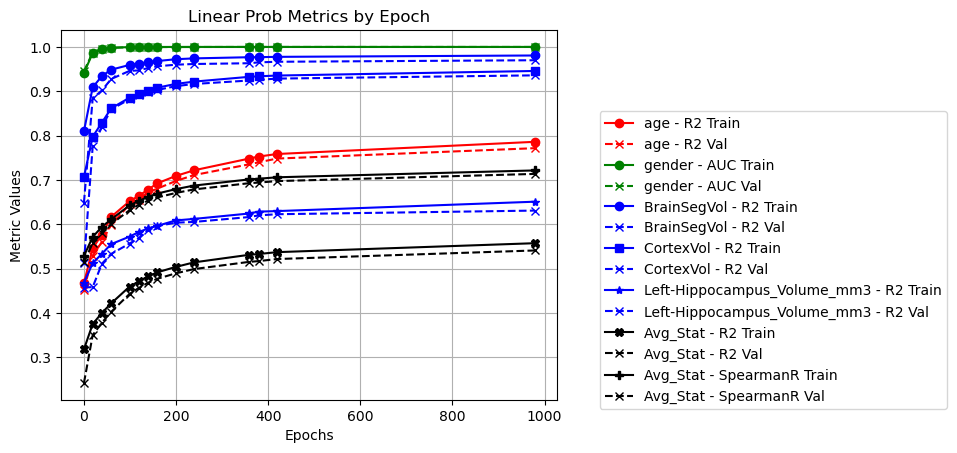

In [125]:
# Plot each column in the DataFrame
cmap = {'age':'red', 'gender':'g', 'BrainSegVol':'b', 'CortexVol':'b',
       'Left-Hippocampus_Volume_mm3':'b', 'Avg_Stat': 'black'}
marker_map = {'age':'o', 'gender':'o', 'BrainSegVol':'o', 'CortexVol':'s',
       'Left-Hippocampus_Volume_mm3':'*', 'Avg_Stat': 'X'}
for column in partial_task + ['Avg_Stat']:  # Exclude the 'epoch_num' column
    # Get the r2 or auc metrics from the dictionary in each cell of the DataFrame
    r2_train = [d.get('r2_train', None) for d in lin_prob_metrics[column]]
    r2_val = [d.get('r2_val', None) for d in lin_prob_metrics[column]]
    spearmanr_train = [d.get('spearmanr_train', None) for d in lin_prob_metrics[column]]
    spearmanr_val = [d.get('spearmanr_val', None) for d in lin_prob_metrics[column]]
    auc_train = [d.get('auc_train', None) for d in lin_prob_metrics[column]]
    auc_val = [d.get('auc_val', None) for d in lin_prob_metrics[column]]
    
    # Plot R2 metrics
    if any(r2_train):  # Check if there are any values for r2_train
        plt.plot(lin_prob_metrics['epoch'], r2_train, label=f'{column} - R2 Train',
                 marker=marker_map[column], linestyle='-', color=cmap[column])
    if any(r2_val):  # Check if there are any values for r2_val
        plt.plot(lin_prob_metrics['epoch'], r2_val, label=f'{column} - R2 Val', 
                 marker='x', linestyle='--', color=cmap[column])
    if column=='Avg_Stat':
        plt.plot(lin_prob_metrics['epoch'], spearmanr_train, label=f'{column} - SpearmanR Train',
                 marker='P', linestyle='-', color=cmap[column])
        plt.plot(lin_prob_metrics['epoch'], spearmanr_val, label=f'{column} - SpearmanR Val',
                 marker='x', linestyle='--', color=cmap[column])
    # Plot AUC metrics
    if any(auc_train):  # Check if there are any values for auc_train
        plt.plot(lin_prob_metrics['epoch'], auc_train, label=f'{column} - AUC Train', 
                 marker=marker_map[column], linestyle='-', color=cmap[column])
    if any(auc_val):  # Check if there are any values for auc_val
        plt.plot(lin_prob_metrics['epoch'], auc_val, label=f'{column} - AUC Val', 
                 marker='x', linestyle='--', color=cmap[column])

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Metric Values')
plt.title('Linear Prob Metrics by Epoch')
plt.legend(loc='best', bbox_to_anchor=(1.8,0.8))
plt.grid(True)

# Show the plot
plt.show()


# k Nearest Neighbors, k=20

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from scipy.stats import spearmanr

KNN_PROB = {}
KNN_PROB_PRED = {}

# Loop through each epoch in the embedding data
for epoch in EMBEDD_DATA.keys():
    KNN_PROB[epoch] = {}
    KNN_PROB_PRED[epoch] = {}
    
    if 'train' in EMBEDD_DATA[epoch].keys() and 'val' in EMBEDD_DATA[epoch].keys():
        # Iterate through each task in partial_task
        for target in partial_task:  # partial_task, all_task
            KNN_PROB[epoch][target] = {}
            KNN_PROB_PRED[epoch][target] = {}
            
            # Extract training and validation targets
            y_train = pretrain_meta_data_train[target]
            y_test = pretrain_meta_data_val[target]
            
            # Condition to remove -99 values from the data
            cond_train = y_train != -99
            cond_test = y_test != -99
            
            # Select training and test data based on the condition
            X_train = EMBEDD_DATA[epoch]['train'][cond_train]
            X_test = EMBEDD_DATA[epoch]['val'][cond_test]
            y_train = y_train[cond_train]
            y_test = y_test[cond_test]
            
            # 2. Create the pipeline with scaling and KNN
            if target != 'gender':  # Regression task (use KNeighborsRegressor)
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),      # Step 1: Standardize the data
                    ('knn', KNeighborsRegressor(n_neighbors=20))  # Step 2: Fit a KNN regressor
                ])
            else:  # Classification task (use KNeighborsClassifier)
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),      # Step 1: Standardize the data
                    ('knn', KNeighborsClassifier(n_neighbors=20))  # Step 2: Fit a KNN classifier
                ])
            
            # 3. Fit the pipeline on the training data
            pipeline.fit(X_train, y_train)

            if target != 'gender':
                # 4. Make predictions on the train and test sets
                y_pred_train = pipeline.predict(X_train)
                y_pred_test = pipeline.predict(X_test)
                
                # 5. Evaluate the model
                r2_train = r2_score(y_train, y_pred_train)  # R-squared score
                spearmanr_train, _ = spearmanr(y_train, y_pred_train)
                r2_test = r2_score(y_test, y_pred_test)  # R-squared score
                spearmanr_test, _ = spearmanr(y_test, y_pred_test)
                
                # Save the results in the dictionary
                KNN_PROB[epoch][target]['r2_train'] = r2_train
                KNN_PROB[epoch][target]['r2_val'] = r2_test
                KNN_PROB[epoch][target]['spearmanr_train'] = spearmanr_train
                KNN_PROB[epoch][target]['spearmanr_val'] = spearmanr_test
                print(epoch, target, KNN_PROB[epoch][target]['r2_val'], KNN_PROB[epoch][target]['spearmanr_val'])
            else:
                # 4. Make predictions on the test set for classification
                y_pred_train = pipeline.predict_proba(X_train)[:, 1]
                y_pred_test = pipeline.predict_proba(X_test)[:, 1]
                
                # 5. Evaluate the model using ROC AUC score
                auc_train = roc_auc_score(y_train, y_pred_train)  # AUC score
                auc_test = roc_auc_score(y_test, y_pred_test)  # AUC score
                
                # Save the results in the dictionary
                KNN_PROB[epoch][target]['auc_train'] = auc_train
                KNN_PROB[epoch][target]['auc_val'] = auc_test
                print(epoch, target, KNN_PROB[epoch][target]['auc_val'])


epoch_359 age 0.4490152101497471 0.657914027301387
epoch_359 gender 0.9990709937738839
epoch_359 BrainSegVol 0.7166241212169946 0.8657521960299803
epoch_359 CortexVol 0.6365931299434772 0.8164862639795538
epoch_359 Left-Hippocampus_Volume_mm3 0.3626672784893431 0.5891056311436097
epoch_379 age 0.4540540587926889 0.6626886592165527
epoch_379 gender 0.9988869368952551
epoch_379 BrainSegVol 0.7174530264985381 0.8665251856506184
epoch_379 CortexVol 0.6367805213000463 0.8163032620242127
epoch_379 Left-Hippocampus_Volume_mm3 0.36114070218448324 0.5868440607543098
epoch_199 age 0.41092720085756473 0.6222504117623763
epoch_199 gender 0.9989708237093708
epoch_199 BrainSegVol 0.7222940480415658 0.8707330660505224
epoch_199 CortexVol 0.6238526627609418 0.8080349610110314
epoch_199 Left-Hippocampus_Volume_mm3 0.34404118273637996 0.5766219952878098
epoch_159 age 0.3939698840325242 0.6098217226345127
epoch_159 gender 0.9987267995499685
epoch_159 BrainSegVol 0.7207058488958169 0.873466947320345
epoch

In [95]:
knn_prob_metrics = pd.DataFrame(KNN_PROB).T
n_target = knn_prob_metrics.shape[1]
# Extract the epoch numbers as integers
knn_prob_metrics['epoch'] = knn_prob_metrics.index.map(lambda x: int(x.split('_')[1]))
knn_prob_metrics = knn_prob_metrics.sort_values(by='epoch')
knn_prob_metrics = knn_prob_metrics.dropna()


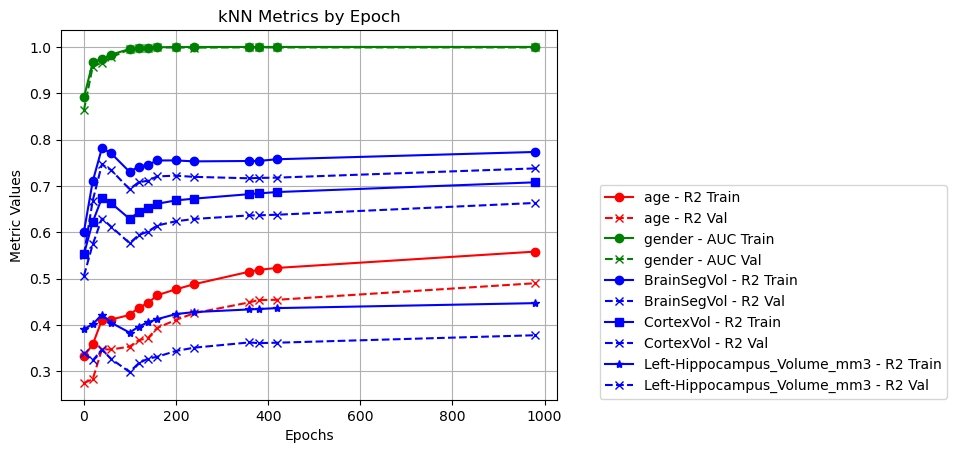

In [96]:
# Plot each column in the DataFrame
cmap = {'age':'red', 'gender':'g', 'BrainSegVol':'b', 'CortexVol':'b',
       'Left-Hippocampus_Volume_mm3':'b'}
marker_map = {'age':'o', 'gender':'o', 'BrainSegVol':'o', 'CortexVol':'s',
       'Left-Hippocampus_Volume_mm3':'*'}

for column in knn_prob_metrics.columns[:-1]:  # Exclude the 'epoch_num' column
    # Get the r2 or auc metrics from the dictionary in each cell of the DataFrame
    r2_train = [d.get('r2_train', None) for d in knn_prob_metrics[column]]
    r2_val = [d.get('r2_val', None) for d in knn_prob_metrics[column]]
    auc_train = [d.get('auc_train', None) for d in knn_prob_metrics[column]]
    auc_val = [d.get('auc_val', None) for d in knn_prob_metrics[column]]
    
    # Plot R2 metrics
    if any(r2_train):  # Check if there are any values for r2_train
        plt.plot(knn_prob_metrics['epoch'], r2_train, label=f'{column} - R2 Train',
                 marker=marker_map[column], linestyle='-', color=cmap[column])
    if any(r2_val):  # Check if there are any values for r2_val
        plt.plot(knn_prob_metrics['epoch'], r2_val, label=f'{column} - R2 Val', 
                 marker='x', linestyle='--', color=cmap[column])
    
    # Plot AUC metrics
    if any(auc_train):  # Check if there are any values for auc_train
        plt.plot(knn_prob_metrics['epoch'], auc_train, label=f'{column} - AUC Train', 
                 marker=marker_map[column], linestyle='-', color=cmap[column])
    if any(auc_val):  # Check if there are any values for auc_val
        plt.plot(knn_prob_metrics['epoch'], auc_val, label=f'{column} - AUC Val', 
                 marker='x', linestyle='--', color=cmap[column])

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Metric Values')
plt.title('kNN Metrics by Epoch')
plt.legend(loc='best', bbox_to_anchor=(1.8,0.6))
plt.grid(True)

# Show the plot
plt.show()
